# Try HMM

Not entirely sure how these work but will word it out as I go along.


https://towardsdatascience.com/hidden-markov-models-for-time-series-classification-basic-overview-a59b74e5e65b
    Normally towardsdatascience is really good but this makes no sense to me at all.

This article is more complicated, but also indepth and explains stuff more. - https://towardsdatascience.com/markov-chains-and-hmms-ceaf2c854788

Some guys github repository using HMM for binary sentimental analysis of tweets - https://github.com/FantacherJOY/Hidden-Markov-Model-for-NLP


"In the case one label is way more frequent than the other (say Class B appears for every 100 samples of Class A), or in the case one category is broader than the other (have more variance, i.e. Class A is an expected behavior of a process and Class B is all the cases that are abnormal), then we might want to train a unique HMM for Class A. For each new sample, we compute the likelihood to the model, and if it falls below a pre-defined threshold (that can be chosen with respect to some validation sample, or in the worst case, from the training samples themselves) we assign this sample to Class B. If the likelihood is above the threshold, we assign the sample to Class A." - https://datascience.stackexchange.com/questions/8560/can-hmm-be-used-as-a-binary-classifier

In [1]:
# imports
from hmmlearn import hmm
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt

# Load in data
# index_col stops index being read as column
df_turk = pd.read_csv('turk-Data-renamed.csv', index_col=0)
df_lab = pd.read_csv('lab-Data-renamed.csv', index_col=0)

In [2]:
# Load in data

# Data Engineering

Initial exploration shown to be promising.
Now do some data engineering to get the targets into the format I want.

In [3]:
# First get the targets data in a time series of time, target, and ID.

# When we remove the mouse event we have much more duplicate data.
# Drop this data and reset the indexes to account for missing values.
# Since there was a correlation between time and number of mouse events maybe I can use index to substitue for time.

df_m_lab = df_lab[['target', 'time', 'turkId']]     # m for markov
lab_dups = len(df_m_lab)-len(df_m_lab.drop_duplicates())
print(f'Number of duplicate items in lab data: {lab_dups}')
print(f'Percentage duplicate: {lab_dups / len(df_lab) * 100}\n')
df_m_lab = df_m_lab.drop_duplicates()

df_m_turk = df_turk[['target', 'time', 'turkId']]
turk_dups = len(df_m_turk)-len(df_m_turk.drop_duplicates())
print(f'Number of duplicate items in turk data: {turk_dups}')
print(f'Percentage duplicate: {turk_dups / len(df_m_turk) * 100}')
df_m_turk = df_m_turk.drop_duplicates()

df_m_lab

Number of duplicate items in lab data: 9482
Percentage duplicate: 25.309630578688875

Number of duplicate items in turk data: 180378
Percentage duplicate: 21.656231428176945


,target,time,turkId
0,alloc-slider-5,0.000000,ID1
1,alloc-slider-5,0.547000,ID1
3,alloc-slider-5,1.176995,ID1
4,alloc-slider-5,1.790000,ID1
5,html,2.896995,ID1
...,...,...,...
58261,alloc-slider-2,273.796495,ID18
58263,alloc-slider-2,273.836415,ID18
58265,alloc-slider-2,273.924560,ID18
58270,html,274.968440,ID18


In [4]:
# TODO: Might have to convert targets to numerical representation, maybe one-hot encoding?

# Replace html with 0, and alloc-slider-1 to 1, alloc-slider-2 to 2, alloc-slider-3 to 3, alloc-slider-4 to 4, alloc-slider-5 to 5

df_m_lab.loc[df_m_lab['target'].str.contains('html'), 'target'] = '0'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-1'), 'target'] = '1'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-2'), 'target'] = '2'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-3'), 'target'] = '3'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-4'), 'target'] = '4'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-5'), 'target'] = '5'
data_lab = df_m_lab['target'].to_numpy().reshape(-1, 1)

df_m_turk.loc[df_m_turk['target'].str.contains('html'), 'target'] = '0'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-1'), 'target'] = '1'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-2'), 'target'] = '2'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-3'), 'target'] = '3'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-4'), 'target'] = '4'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-5'), 'target'] = '5'
data_turk = df_m_turk['target'].astype('int32').to_numpy().reshape(-1, 1)
data_turk.shape

(652537, 1)

In [5]:
# we want to have everything in one long array like this.
# But then we need to create the lengths array thing.

lab_lengths = []
for ID in df_m_lab['turkId'].unique():
    length_for_ID = len( df_m_lab[df_m_lab['turkId'] == ID] )
    lab_lengths.append(length_for_ID)

turk_lengths = []
for ID in df_m_turk['turkId'].unique():
    length_for_ID = len( df_m_turk[df_m_turk['turkId'] == ID] )
    turk_lengths.append(length_for_ID)

lab_lengths

[2267,
 2341,
 2341,
 646,
 597,
 3116,
 1531,
 490,
 2666,
 469,
 3754,
 3754,
 2005,
 2005]

In [6]:
# Create Lab data HMM

# Suggestions for number of hidden states.
# https://www.researchgate.net/post/Is_there_any_simple_rule_for_the_number_of_states_in_HMM

# Picked 6 hidden states as thats what the actual system has. sliders 1-5 and other
lab_model = hmm.GaussianHMM(n_components=6, verbose=True).fit(data_lab, lab_lengths) # dont know how many components/hidden states I should have
lab_model

1      -56759.1163             +nan
         2      -47711.6643       +9047.4520
         3      -40440.3305       +7271.3338
         4      -36838.0855       +3602.2450
         5      -33898.1212       +2939.9643
         6      -25847.4826       +8050.6386
         7       -8453.8532      +17393.6294
         8       39070.2582      +47524.1114
         9       56067.9756      +16997.7174
        10       99424.0314      +43356.0558


GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=6, n_iter=10, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=True)

In [7]:
lab_model.sample(10)

(array([[0.04136433],
        [0.99990829],
        [2.00107362],
        [1.99954536],
        [2.00067807],
        [1.99972359],
        [2.00037859],
        [1.99869493],
        [1.99908865],
        [1.9998541 ]]),
 array([5, 0, 4, 4, 4, 4, 4, 4, 4, 4]))

In [8]:
# Lab Transition Matrix
np.round(lab_model.transmat_, 3)

array([[0.941, 0.005, 0.007, 0.003, 0.027, 0.017],
       [0.005, 0.948, 0.005, 0.021, 0.006, 0.015],
       [0.005, 0.005, 0.942, 0.019, 0.018, 0.011],
       [0.001, 0.019, 0.012, 0.953, 0.002, 0.014],
       [0.015, 0.004, 0.02 , 0.002, 0.948, 0.012],
       [0.025, 0.018, 0.015, 0.015, 0.013, 0.913]])

In [9]:
turk_model = hmm.GaussianHMM(n_components=6, verbose=True).fit(data_turk.reshape(-1, 1), turk_lengths) # dont know how many components/hidden states I should have
turk_model

1    -1362170.3784             +nan
         2    -1168812.4272     +193357.9513
         3     -980231.5847     +188580.8425
         4     -890578.3868      +89653.1978
         5     -820547.0694      +70031.3174
         6     -652062.7092     +168484.3603
         7     -424897.2640     +227165.4452
         8      250420.6334     +675317.8974
         9     1672130.3103    +1421709.6769
        10     3958857.5252    +2286727.2149


GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=6, n_iter=10, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=True)

In [10]:
# Show transition matrix of hidden states.
# TODO: compute actual system trasitions with n-grams.

np.round(turk_model.transmat_, 2)

array([[0.93, 0.02, 0.02, 0.01, 0.01, 0.02],
       [0.02, 0.94, 0.01, 0.  , 0.02, 0.01],
       [0.02, 0.  , 0.95, 0.01, 0.  , 0.01],
       [0.02, 0.  , 0.02, 0.95, 0.  , 0.  ],
       [0.02, 0.01, 0.  , 0.  , 0.95, 0.  ],
       [0.03, 0.02, 0.01, 0.  , 0.  , 0.93]])

In [11]:
# Create a new data samples of length 10.

np.round(np.array(turk_model.sample(10)[0]).reshape(-1),2)


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [12]:

# Have to have all this extra code because the data is stored in a big long list so need to kind of extract the user details again.

def model_score_list(model, data, lengths):
    # Given a model and some data and lengths return a list of likelihoods that each different data sample belongs to that HMM.

    probas = []

    start_i = 0
    #end_i = start_i + lab_lengths[0]
    end_i = 0

    for i in range(len(lengths)):
        end_i = start_i + lengths[i]

        users_items = data[start_i:end_i]
        
        #print(i)
        #print( model.score( users_items ) )
        probas.append( model.score(users_items) )

        start_i = lengths[i] # lab_lengths[0]
        #end_i = start_i + lab_lengths[i+1]

    return probas

model_score_list(turk_model, data_lab, lab_lengths)    # Try lab data on turk model

[15321.819068806899,
 15933.351630944073,
 15935.68508753155,
 4296.340267088942,
 4073.787478618482,
 21229.52196168136,
 10521.516918091947,
 3380.5200035298208,
 18104.632754825645,
 3181.310129336032,
 25630.308427393487,
 25590.183258767178,
 13596.270240148784,
 13605.720619410204]

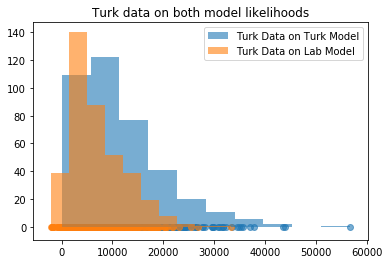

In [13]:
turk_data_turk_model = model_score_list(turk_model, data_turk, turk_lengths)  # Try turk data on turk model
turk_data_lab_model = model_score_list(lab_model, data_turk, turk_lengths)  # Try turk data on lab model

plt.hist(turk_data_turk_model, bins=10, label='Turk Data on Turk Model', alpha=0.6)
plt.hist(turk_data_lab_model, bins=10, label='Turk Data on Lab Model', alpha=0.6)

plt.title('Turk data on both model likelihoods')
plt.legend(loc='best')

# Also show the individual points on there too because why not.
plt.scatter( turk_data_turk_model, np.zeros((len(turk_data_turk_model),1)), label='Turk Data on Turk Model', alpha=0.6 )
plt.scatter( turk_data_lab_model, np.zeros((len(turk_data_lab_model),1)), label='Turk Data on Lab Model', alpha=0.6 )

plt.show()

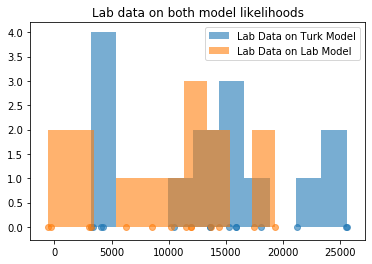

In [14]:
lab_data_turk_model = model_score_list(turk_model, data_lab, lab_lengths)  # Try lab data on turk model
lab_data_lab_model = model_score_list(lab_model, data_lab, lab_lengths)  # Try lab data on lab model

plt.hist(lab_data_turk_model, bins=10, label='Lab Data on Turk Model', alpha=0.6)
plt.hist(lab_data_lab_model, bins=10, label='Lab Data on Lab Model', alpha=0.6)

plt.title('Lab data on both model likelihoods')
plt.legend(loc='best')

# Also show the individual points on there too because why not.
plt.scatter( lab_data_turk_model, np.zeros((len(lab_data_turk_model),1)), label='Lab Data on Turk Model', alpha=0.6 )
plt.scatter( lab_data_lab_model, np.zeros((len(lab_data_lab_model),1)), label='Lab Data on Lab Model', alpha=0.6 )

plt.show()

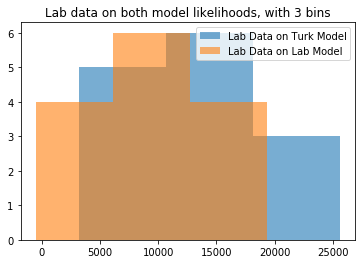

In [15]:
# This graph clearly shows that on average, the lab data is more likely to be classified as a turk model.

plt.hist(lab_data_turk_model, bins=3, label='Lab Data on Turk Model', alpha=0.6)
plt.hist(lab_data_lab_model, bins=3, label='Lab Data on Lab Model', alpha=0.6)

plt.title('Lab data on both model likelihoods, with 3 bins')
plt.legend(loc='best')
plt.show()

In [16]:
print(lab_model.score(data_lab, lab_lengths))
print(turk_model.score(data_lab, lab_lengths))
print()
print(lab_model.score(data_turk, turk_lengths))
print(turk_model.score(data_turk, turk_lengths))

135568.91802880744
191936.57919231648

2877439.5699009816
4491847.116146446


In [17]:
lab_data_turk_model
lab_data_lab_model
turk_data_turk_model
turk_data_lab_model 

[1868.9064738183197,
 3180.6845184781187,
 3661.7013141890775,
 4177.4515274925925,
 896.4816163722925,
 -1451.2059989031695,
 1510.929373570716,
 3540.1244816308417,
 12330.066044227833,
 1526.431391351089,
 3539.3834308762675,
 10322.698822537568,
 1415.4498950806212,
 1900.564210060337,
 3998.3074160171145,
 6410.91015935433,
 -882.6221050398931,
 1664.518997969993,
 2866.3968248298133,
 2424.3454367393288,
 7128.4889960278915,
 13834.594914149176,
 12707.908483239844,
 6464.849838458663,
 2103.136345036737,
 13710.34468738524,
 2822.6353799413837,
 8980.191475791713,
 7637.432201930806,
 14490.8943256722,
 1696.0736044026312,
 3224.2044720559,
 1132.6246753224839,
 19209.591215666715,
 2152.387779838222,
 -320.2000407275551,
 6475.174088938871,
 16516.959021047587,
 4647.634498995759,
 13351.743242919696,
 20520.88867514327,
 3244.232502430203,
 8100.02805655043,
 5082.345872545192,
 14154.103443515794,
 6653.763287565258,
 1406.7952851671632,
 14336.192984878202,
 7794.98926342873

# Plotting results

It is hard to visulaise these results, so show them as a scatter point and a 2D histogram.
A straight line of y = x will be shown.
A point on this line will have the identily likelihoods to belong to either model.



(0, 60000)

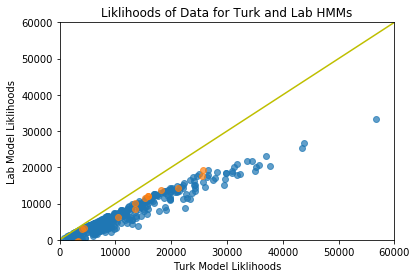

In [61]:
plt.scatter(turk_data_turk_model, turk_data_lab_model, alpha=0.7)
plt.scatter(lab_data_turk_model, lab_data_lab_model, alpha=0.7)
plt.plot(range(60000), c='y')
plt.title('Liklihoods of Data for Turk and Lab HMMs')
plt.xlabel('Turk Model Liklihoods')
plt.ylabel('Lab Model Liklihoods')
plt.xlim(0, 60000)
plt.ylim(0, 60000)
# TODO: Create a 2d histogram to better show the distribution.
# TODO: Make x and y same size and scale, while plotting a straight line of y=x 

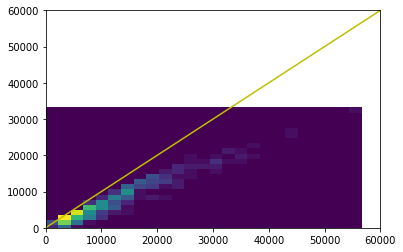

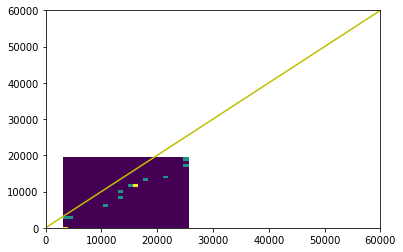

In [75]:
plt.hist2d(turk_data_turk_model, turk_data_lab_model, bins=25);
plt.xlim(0, 60000)
plt.ylim(0, 60000)
plt.plot(range(60000), c='y')
plt.show()

plt.hist2d(lab_data_turk_model, lab_data_lab_model, bins=25);
plt.xlim(0, 60000)
plt.ylim(0, 60000)
plt.plot(range(60000), c='y')
plt.show()

# Reassigning samples

Now run all lab and turk data through both models. 
Assign a predicted label (lab / online) data.
Afterwards compare actual and predicted to see if any samples seem to be missclassified.  

In [86]:

# Have to have all this extra code because the data is stored in a big long list so need to kind of extract the user details again.

def reclassify_samples(turk_model, lab_model, data, lengths):
    # Given a model and some data and lengths return a list of predicted new classes.

    new_classes = []

    start_i = 0
    end_i = 0

    for i in range(len(lengths)):
        end_i = start_i + lengths[i]

        users_items = data[start_i:end_i]
        
        # Turks are 0, labs are 1

        turk_likelihood = turk_model.score(users_items)
        lab_likelihood = lab_model.score(users_items)

        print(f'User {i}: \t turk: {int(turk_likelihood)}, \t lab: {int(lab_likelihood)}')

        if ( turk_likelihood > lab_likelihood ):
            new_classes.append(0)
        else:
            new_classes.append(1)

        start_i = lengths[i] 

    return new_classes

reclassify_samples(turk_model, lab_model, data_lab, lab_lengths)    # Try lab data

User 0: 	 turk: 15321, 	 lab: 11504
User 1: 	 turk: 15933, 	 lab: 11965
User 2: 	 turk: 15935, 	 lab: 11967
User 3: 	 turk: 4296, 	 lab: 3179
User 4: 	 turk: 4073, 	 lab: 3068
User 5: 	 turk: 21229, 	 lab: 14385
User 6: 	 turk: 10521, 	 lab: 6266
User 7: 	 turk: 3380, 	 lab: -315
User 8: 	 turk: 18104, 	 lab: 13686
User 9: 	 turk: 3181, 	 lab: -532
User 10: 	 turk: 25630, 	 lab: 19323
User 11: 	 turk: 25590, 	 lab: 17532
User 12: 	 turk: 13596, 	 lab: 8532
User 13: 	 turk: 13605, 	 lab: 10210


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [87]:
reclassify_samples(turk_model, lab_model, data_turk, turk_lengths)    # Try turk data

User 0: 	 turk: 2467, 	 lab: 1868
User 1: 	 turk: 4227, 	 lab: 3180
User 2: 	 turk: 6973, 	 lab: 3661
User 3: 	 turk: 5598, 	 lab: 4177
User 4: 	 turk: 1241, 	 lab: 896
User 5: 	 turk: 1979, 	 lab: -1451
User 6: 	 turk: 2947, 	 lab: 1510
User 7: 	 turk: 5634, 	 lab: 3540
User 8: 	 turk: 17405, 	 lab: 12330
User 9: 	 turk: 6795, 	 lab: 1526
User 10: 	 turk: 4572, 	 lab: 3539
User 11: 	 turk: 14880, 	 lab: 10322
User 12: 	 turk: 2808, 	 lab: 1415
User 13: 	 turk: 6368, 	 lab: 1900
User 14: 	 turk: 5237, 	 lab: 3998
User 15: 	 turk: 12539, 	 lab: 6410
User 16: 	 turk: 2723, 	 lab: -882
User 17: 	 turk: 6061, 	 lab: 1664
User 18: 	 turk: 3788, 	 lab: 2866
User 19: 	 turk: 3248, 	 lab: 2424
User 20: 	 turk: 10500, 	 lab: 7128
User 21: 	 turk: 19460, 	 lab: 13834
User 22: 	 turk: 22594, 	 lab: 12707
User 23: 	 turk: 11376, 	 lab: 6464
User 24: 	 turk: 2978, 	 lab: 2103
User 25: 	 turk: 20133, 	 lab: 13710
User 26: 	 turk: 4124, 	 lab: 2822
User 27: 	 turk: 14179, 	 lab: 8980
User 28: 	 turk:

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


Turk Likelihoods  Lab likelihoods   Difference   ID
0      15321.819069     11504.840623  3816.978446  ID1
1      15933.351631     11965.638879  3967.712752  ID2
2      15935.685088     11967.170294  3968.514793  ID3
3       4296.340267      3179.095060  1117.245207  ID4
4       4073.787479      3068.238735  1005.548744  ID5


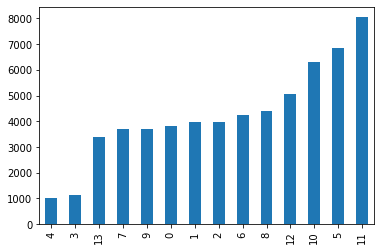

In [147]:
def compare_model_liklihoods(turk_model, lab_model, data, lengths, IDs):
    # Given a model and some data and lengths return a dataframe of each user, and the liklihoods for different models.
    # Difference is turklikelihood - lab_liklihood.
    # Therefore a high positive number means its firmly turk, a low negative number means its firmly lab.

    res = []

    start_i = 0
    end_i = 0

    for i in range(len(lengths)):
        end_i = start_i + lengths[i]

        users_items = data[start_i:end_i]

        turk_likelihood = turk_model.score(users_items)
        lab_likelihood = lab_model.score(users_items)
        difference = turk_likelihood - lab_likelihood
        ID = IDs[i]

        res.append( (turk_likelihood, lab_likelihood, difference, ID) )

        start_i = lengths[i] 

    df = pd.DataFrame.from_records(res, columns =['Turk Likelihoods', 'Lab likelihoods', 'Difference', 'ID']) 

    return df

df_lab_diff = compare_model_liklihoods(turk_model, lab_model, data_lab, lab_lengths, df_m_lab['turkId'].unique().tolist())    # Try lab data
print(df_lab_diff.head())
df_lab_diff['Difference'].sort_values().plot(kind='bar')

Turk Likelihoods  Lab likelihoods   Difference              ID
0       2467.729921      1868.906474   598.823447  A35YFAFWP33C70
1       4227.312727      3180.684518  1046.628208  A33XI8ZN4NZ0SQ
2       6973.295307      3661.701314  3311.593993  A1ZG7VYH0DUEXW
3       5598.289015      4177.451527  1420.837488  A1RXG8RE0SJ4LC
4       1241.206092       896.481616   344.724476   AUDH0P4ZHJKS2


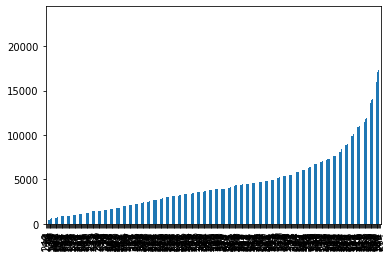

In [148]:
df_turk_diff = compare_model_liklihoods(turk_model, lab_model, data_turk, turk_lengths, df_m_turk['turkId'].unique())    # Try turk data
print(df_turk_diff.head())
df_turk_diff['Difference'].sort_values().plot(kind='bar')

# AMAZING IDEA

hmmlearn has the function .SAMPLE(n). This Generates random samples from the model.

With some effort could potentially use this to generate new samples for lab data!

In [21]:
# See if lab_lengths follow a normal distribution
# Lab lengths kind of follow this distribution but not really.
#https://stackoverflow.com/questions/20011122/fitting-a-normal-distribution-to-1d-data
'''
from scipy.stats import norm
from scipy.stats import lognorm

plt.hist(turk_lengths, bins=25, density=True, alpha=0.6, color='b')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

mu, std = norm.fit(turk_lengths)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)

#dist=lognorm([std],loc=mean)
lognorm_dist = lognorm(s=std, loc=mu)
p2 = lognorm(*lnorm)

plt.plot(x, lognorm_dist.pdf(x), 'y', linewidth=2)

title = "Turk Lengths - Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()
''';

In [111]:
from scipy.stats import norm

data = turk_lengths
ogdata = np.log(data)
estimated_mu, estimated_sigma = norm.fit(logdata)

x = np.linspace(xmin, xmax, 100)
pdf = norm.pdf(x, loc=estimated_mu, scale=estimated_sigma)
plt.plot(x, pdf, 'k')

NameError: name 'xmin' is not defined

In [0]:
turk_lengths

In [0]:
plt.hist(turk_lengths, bins=20, density=True, alpha=0.6, color='b')

In [0]:


# plot histogram in log space
logdata = np.log(data)
plt.hist(logdata, bins=25)


In [0]:
shape,loc,scale = lognorm.fit(data)

x = np.logspace(0, 5, 200)
pdf = lognorm.pdf(x, shape, loc, scale)

plt.plot(x, pdf, 'r')

In [0]:
# See if Lab data follows a distrinution

mu, std = norm.fit(lab_lengths)

plt.hist(lab_lengths, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
title = "Lab Lengths - Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

In [0]:
# Both on 1 graph?

mu, std = norm.fit(lab_lengths)

plt.hist(lab_lengths, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'y', linewidth=2)
plt.title('Both distributions on same plot')

mu, std = norm.fit(turk_lengths)

plt.hist(turk_lengths, bins=25, density=True, alpha=0.6, color='b')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)

plt.show()

In [0]:
# Combine both data together and see what the distribution looks like
# Probably a bit pointless as the turk data will still be so much more numerous

both_lengths = np.append(turk_lengths,lab_lengths)
both_lengths = np.array(np.append(turk_lengths,lab_lengths), dtype=float)

mu, std = norm.fit(both_lengths)

plt.hist(both_lengths, bins=100, density=True, alpha=0.6, color='y')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
title = "Both Lengths - Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

# Length Distributions.
Thought this would be a failure at first but this is actually really amazing!
Can CLEARLY see a distribution off turk lengths, and we could explain you not seeing a distribtion in lab data because there is so little many samples.

For Turk and Lab the means are:

|  | Mean | S.D |
| --- | --- | --- |
| Turk | 1677 | 1235 |
| Lab | 1998 | 1095 |

Which are not identical, but as I've showed with the ealier PCA attempts lengths cannot be used to differenciate data points.
Theyre similar enough that I can assume they follow the SAME distribtion.


# Synthesize data
We can generate sequences of any length specified.
todo sample length from a normal distribution matching the lab or turk data depending on what class im creating more samples for.

At the moment this section creates fixed length samples but that will change.

In [0]:
# Sample points from distributions of lengths, using their mean, and sd.

num_generated_samples = 100

# Wanna generate lab sequences as thats the smaller class.
mu, std = norm.fit(lab_lengths)
generated_lengths = np.random.normal(loc=mu, scale=std, size=num_generated_samples)   # Creating 300 more samples would make the classes even ish.

# https://stackoverflow.com/a/38406535/11902832
# Remove negative values, but now its not really a normal distribution
generated_lengths = abs(generated_lengths).astype(int)



In [0]:
# See if Lab data follows a distrinution

mu, std = norm.fit(lab_lengths)

plt.hist(generated_lengths, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
title = "Generated Lengths "
plt.title(title)

plt.show()

In [0]:
created_data = []
for i in generated_lengths:

    X, Z = lab_model.sample(i)  # This generates a new sample, length of which is taken from the normal distribution

    created_data.append( np.concatenate(X).ravel().astype(int).astype(str).tolist() ) # list of nps flattened, and to ints

len(created_data)

In [0]:
# we have array of length 100, each of which contains events of varing lengths.

IDs = []    # This will be the length of the flattened array. will be like ID1, ID1, ID2 etc
targets = []

for i in range(len(created_data)):    
    targets.extend(created_data[i])

    for j in range(len(created_data[i])):
        IDs.append(f'ID{i}')


In [0]:
df = pd.DataFrame({'target':targets, 'turkId':IDs}) 
df.astype(object)
#df['target'] = df['target'].rename({'0' :'html', '1':'Slider-1', '2':'Sliders-2', '3':'Slider-3', '4':'Slider-4', '5':'Slider-5'})

df['target'] = df['target'].replace('0','html')
df['target'] = df['target'].replace('1','alloc-slider-1')
df['target'] = df['target'].replace('2','alloc-slider-2')
df['target'] = df['target'].replace('3','alloc-slider-3')
df['target'] = df['target'].replace('4','alloc-slider-4')
df['target'] = df['target'].replace('5','alloc-slider-5')

df

In [0]:
df.to_csv('created_labs.csv')

Tableau images https://imgur.com/a/FagaiQW
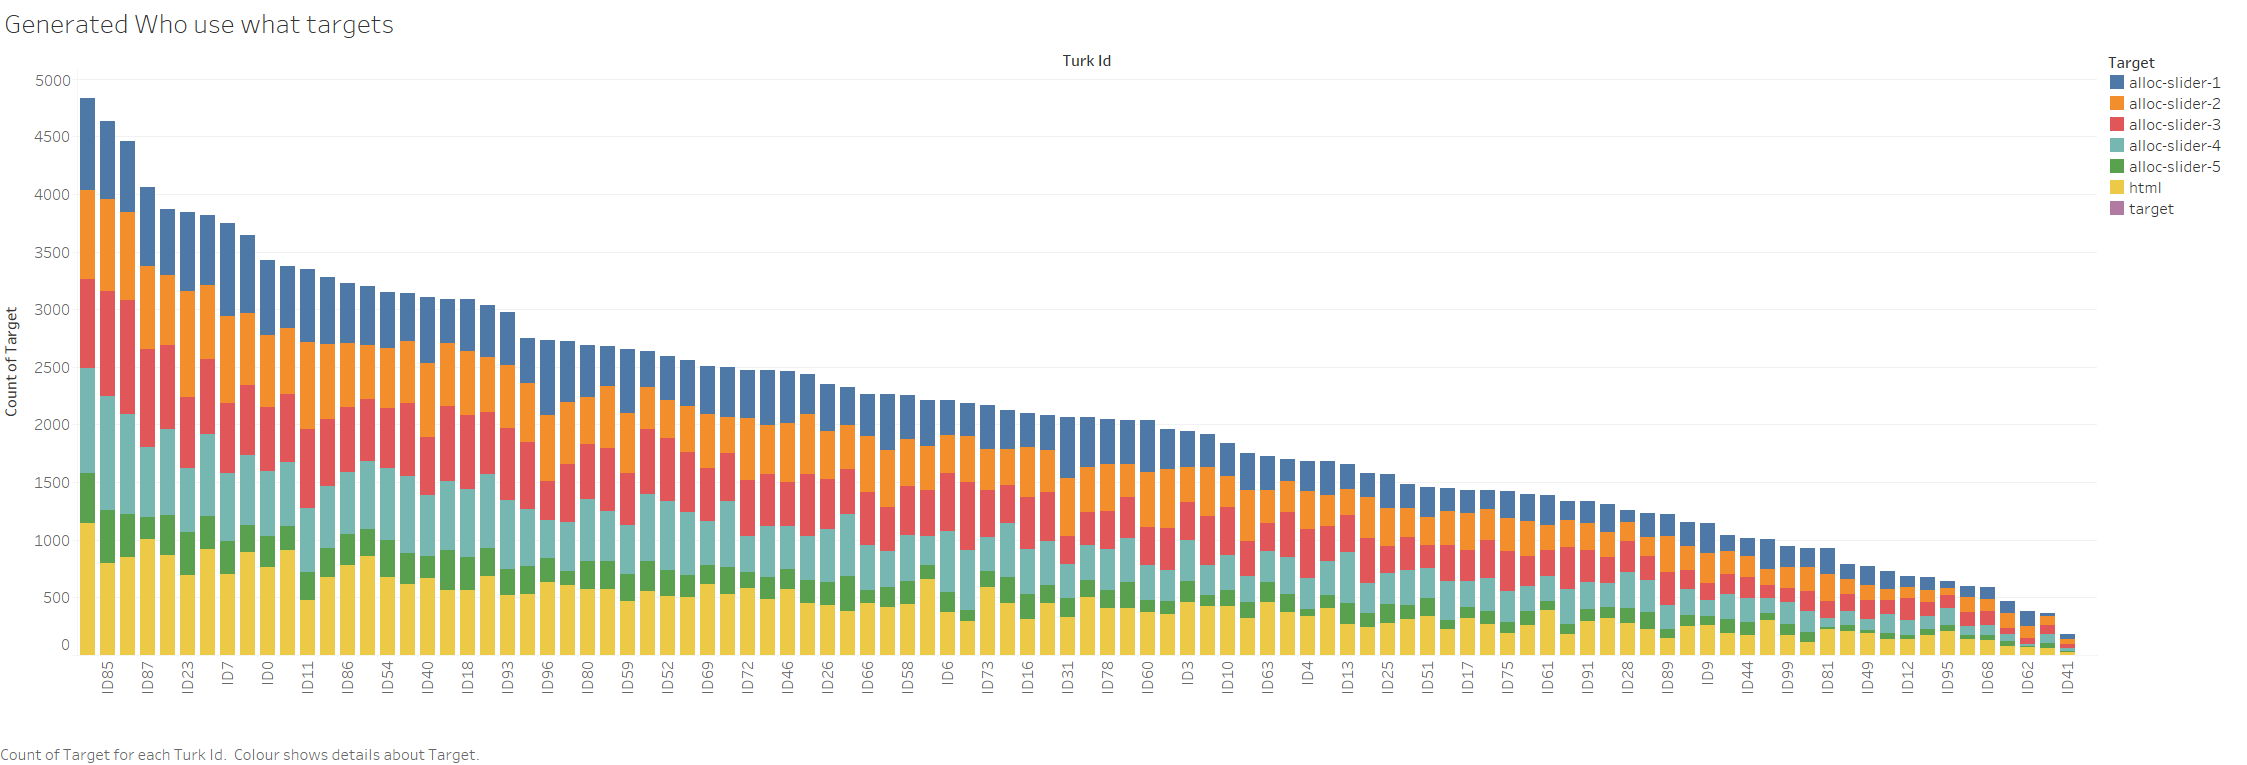

Now weve generated some more data samples see if the generated data sampels would be identified by the lab hmm not the turk hmm.



In [0]:
flatten_created_data = np.concatenate(created_data).ravel().astype(int).reshape(-1,1)

# STILL PREDICTS EVERYTHING AS LAB!

reclassify_samples(turk_model, lab_model, flatten_created_data, generated_lengths)    # Try generated lab data

In [0]:
#idea: maybe the liklihoods are messed up because of the inbalanece in training size when orriginally training?
# Try duplicating training samples NOW, or retrain on the created data.

generated_model = hmm.GaussianHMM(n_components=6, verbose=True).fit(flatten_created_data, generated_lengths.tolist()) # not sure why not working.
generated_model

In [0]:
reclassify_samples(turk_model, generated_model, flatten_created_data, generated_lengths) 

# NLP methods again 

See if the naive bayes of n-grams distribution will work better.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [0]:
created_data

In [0]:
# Converts a pandas datafram of targets to a list of strings
def targets_to_string(dataframe):
    IDs = dataframe['turkId'].unique()
    targets_text = []

    for ID in IDs:
        targets_series = dataframe[ dataframe['turkId'] == ID ] ['target']
        targets =  ','.join(targets_series)
        targets_text.append( targets)
        #targets_text = targets

    return targets_text

turk_targets = targets_to_string(df_turk)
lab_targets = targets_to_string(df_lab)
generated_targets = targets_to_string(df)

turk_labels = np.zeros( len(turk_targets) )
lab_labels = np.ones( len(lab_targets) )
generated_labels = np.ones( len(generated_targets) )


In [0]:
print(len(turk_labels))
print(len(lab_labels))
print(len(generated_labels))
print(len(np.append(lab_labels, generated_labels)))
print(len(turk_labels[:114]))

X = np.concatenate((turk_targets[:114], lab_targets, generated_targets))
y = np.concatenate((turk_labels[:114], lab_labels, generated_labels))

len(X), len(y)

In [0]:
# Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [0]:
# Vectorise data and train NB model

vectorizer = CountVectorizer(token_pattern='(.*?,)') 
counts = vectorizer.fit_transform(X_train)

classifier = MultinomialNB()
targets = y_train
classifier.fit(counts, targets)

example_count = vectorizer.transform(X_test)
predictions = classifier.predict(example_count)

print( f'Accuracy score: {accuracy_score(y_test, predictions)}' )
f1 = f1_score(y_test, predictions, average='macro')
print( f'F1 score: {f1}' )
cm = confusion_matrix(y_test, predictions)
print(cm)

plt.matshow(cm)
plt.title('Confusion matrix')
plt.suptitle('0=online, 1=lab')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [0]:
 # This seems to say that nb finds it easiest to identify lab data as lab data.
 # This makes sence as lab data is created forom an actual model and distribution rather than being created randomly.

 # TODO do with full dataset of 300 for turks, so generate more lab data.

In [0]:
# THen we have to consider the actual question of the dis, can we identify whos paying attention?
# Maybe say the 12ish turks falsly predicted to be labs were paying attention??
# Seems like a big leap to say that.

In [0]:
# Train another to see if results are just from a test train split.

# Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Vectorise data and train NB model

vectorizer = CountVectorizer(token_pattern='(.*?,)') 
counts = vectorizer.fit_transform(X_train)

classifier = MultinomialNB()
targets = y_train
classifier.fit(counts, targets)

# Show training data confusion matrix
train_predictions = classifier.predict(counts)
print(confusion_matrix(y_train, train_predictions))

# Show traditional confusioni matrix
example_count = vectorizer.transform(X_test)
predictions = classifier.predict(example_count)

print( f'Accuracy score: {accuracy_score(y_test, predictions)}' )
f1 = f1_score(y_test, predictions, average='macro')
print( f'F1 score: {f1}' )
cm = confusion_matrix(y_test, predictions)
print(cm)

plt.matshow(cm)
plt.title('Confusion matrix')
plt.suptitle('0=online, 1=lab')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Naive Bayes with N-grams

above did naive bayes on counts of items, see if looking at ngrams effects accuracy.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

vectorizer_ngram = CountVectorizer(token_pattern='(.*?,)', ngram_range=(2, 2))
ngram_counts = vectorizer_ngram.fit_transform(X_train)

In [0]:
classifier = MultinomialNB()
targets = y_train
classifier.fit(ngram_counts, targets)

example_count = vectorizer_ngram.transform(X_test)
predictions = classifier.predict(example_count)

# Show training data confusion matrix
train_predictions = classifier.predict(ngram_counts)
print(confusion_matrix(y_train, train_predictions))

print( f'Accuracy score: {accuracy_score(y_test, predictions)}' )
f1 = f1_score(y_test, predictions, average='macro')
print( f'F1 score: {f1}' )
cm = confusion_matrix(y_test, predictions)
print(cm)

plt.matshow(cm)
plt.title('Confusion matrix')
plt.suptitle('0=online, 1=lab')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [0]:
# AMAZING!!!!!
# Very clearly can seperate the classes looking at the bigrams!!!!!

# Still questions of how to extend that to attention or not lol.
# Potentially add section on how to generate more lab data since we cant do lab studdies because of corona.

In [0]:
# Retry the log normal distribution for histograms.

In [0]:
# TODO: crossvalidataion on the models to remove the test train data split. 

In [0]:
# TODO: train NB with gen lab data, see if it classifies actual lab data as labs.

In [0]:
# TODO: maybe do the same with labs and see if the lab hmm can identify actual lab samples.

In [0]:
# TODO TODO TODO: SEE HOW MUCH LOWER LIKLIHOOD THE LAB DATAPOINTS GET ON THE TURK HMM. IF THEYRE ALL STRONG OUTLIERS (10%-20%) THEN WE CAN SAY THESE POINTS CLEARLY DONT BELONG TO THIS CLASS AND THIS IS BECAUSE AS LAB STUDY PARTICIPANTS THEYRE PAYING ATTENTION WHICH HAS CAUSED THEM TO ACT DIFFERENTLY.  

In [0]:
# Curious TODO: See if the states of the HMM relate to the sequence. for example does slider-1 actually repalte to state 1, or does it relate to state 1 and state 2 or even jsut state 6

# Methodology
(1/2 page to 1 page)

(maybe in methodology) The assumption of this project is that labs are paying attention and turks are not. Therefore if we get any outliers from the turk data, but that are similar to the lab data, then we will say that that online turk user was paying more attention than his peers, and that they were paying attention.

This study (ref) says that only 10% of all people / turk users pay attention during a task.
We will look at the 10% (30ish) of the turk data that looks like it is lab data and day that they were paying attention.
This is just the assumption we have made for the project, unfortuanly the dataset isnt extensive enough for us to fully test this hypothesis.

Limitations 
The data is very limited and holds the project back.
The data is very unbalenced between the two classes, 95% of data is turk, not only does that ruin some intial binary classification attemps as detailed later but it means any data we draw from the lab users is gonna be heavily reliant on 10 people, who could themselves be outliers when compared to the general population.

## Repeated Experiments

Approach of this project was to try many different methods of looking through, classifying, and predicting attentionness of this data.

(Get the actual exploration and ml/data science steps by looking at notebooks.)

### 1 - SVM seperateion methods
Here we look at if a simple hyperplain could seperate the data when looking at similar features the number of mouse evetns and the total time taken to do the task.
It was found that a linear, or hyperbolic(wasnt hyperplain was somthing else) was unable to seperate data.
This was mainly die to the unbalenced classes.

### 2 - Clustering
Didnt do this but its an example point.

### 3 - Naive Bayes
Not very good, when balenced data used cross validation average of 50ish%.

### 4 - Naive Bayes with NGRAMS
More successful but suffered from same ussues.

### 5 - HMM
These can be used for binary classification as described here (https://datascience.stackexchange.com/questions/8560/can-hmm-be-used-as-a-binary-classifier).
Say theyre used to generate samples, maybe in another part as that will probably need more explanation.